# K240 Iteration Example

This example shows how to visualize the iteration process using the Wegstein iteration algorithm on the NIST glass K240.  Simple but realistic standards are used for the elements for which there are not pure elements available.

In [1]:
using NeXLMatrixCorrection
using Gadfly

The material K240 is defined in terms of mass fractions.  Measurement lines and the associated standards and measurement conditions are specified.

In [9]:
mat = material("K240",Dict(n"O"=>0.340023, n"Mg"=>0.030154, n"Si"=>0.186986, n"Ti"=>0.059950, n"Zn"=>0.040168, n"Zr"=>0.074030, n"Ba"=>0.268689),missing)

stds = Dict(
	[ n"O K-L3" ] => atomicfraction("Quartz",Dict(n"Si"=>1,n"O"=>2)),
	[ n"Si K-L3" ] => atomicfraction("Quartz",Dict(n"Si"=>1,n"O"=>2)),
	[ n"Mg K-L3" ] => atomicfraction("MgO",Dict(n"Mg"=>1,n"O"=>1)),
	[ n"Ba L3-M5" ] => atomicfraction("Barium Fluoride",Dict(n"Ba"=>1,n"F"=>2)),
	[ n"Ti K-L3" ] => pure(n"Ti"),
	[ n"Zn K-L3" ] => pure(n"Zn"),
	[ n"Zr L3-M5" ] => pure(n"Zr")
)

e0, toa = 20.0e3, deg2rad(40.0);

The "measured" k-ratios are computed.  These will be used as input to the iteration algorithm.

In [10]:
krs = KRatio[]
for (lines, std) in stds
	elm = element(lines[1])
	zu = ZAF(XPP, ReedFluorescence, mat, lines, e0)
	zs = ZAF(XPP, ReedFluorescence, std, lines, e0)
	k = gZAFc(zu, zs, toa, toa) * mat[elm] / std[elm]
	push!(krs, KRatio(lines, props, props, std, k))
end;

The `RecordinginUpdateRule` iterator is used to wrap and collect data on the `WegsteinUpdateRule`.  The `Iteration` object which describes how the iteration is performed is constructed and passed to `iterateks(...)` to perform the iteration.

In [11]:
up = RecordingUpdateRule(NeXLMatrixCorrection.WegsteinUpdateRule())
iter=Iteration(XPP,ReedFluorescence, updater=up)
res=iterateks(iter, "Result", krs)

Converged in 8 to Result = (Si = 0.1870, Zr = 0.0740, Ba = 0.2687, O = 0.3400, Ti = 0.0599, Mg = 0.0302, Zn = 0.0402)


Now we will use Gadfly to plot the iteration process as recorded by `up`.

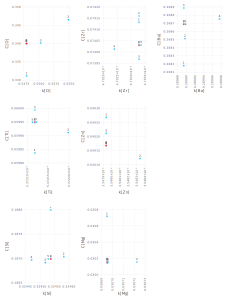

In [12]:
set_default_plot_size(9inch, 12inch)
plot(up, krs, mat)

In [13]:
using BenchmarkTools
iter=Iteration(XPP,ReedFluorescence, updater=WegsteinUpdateRule())
@btime iterateks(iter, "Result", krs)

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1273


  113.297 ms (1500646 allocations: 34.21 MiB)


Converged in 8 to Result = (Si = 0.1870, Zr = 0.0740, Ba = 0.2687, O = 0.3400, Ti = 0.0599, Mg = 0.0302, Zn = 0.0402)
